In [1]:
import numpy as np
import scipy.stats as si
import scipy.stats.mstats
import pandas as pd
import math
import matplotlib.pyplot as plt

In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mpl

In [2]:
def f(x):
    return si.norm.cdf(x, 0.0, 1.0)

def fshock(x):
    #function to fit
    return np.random.normal(0, 0.01) + si.norm.cdf(x, 0.0, 1.0)

def rbfbasis(x, pts, eps):
    res = []
    res.append(np.ones(len(x)))
    res.append(x)
    res.append(np.ones(len(x)) * x * x)
    for pt in pts:
        res.append(np.exp(-eps * (x - pt) * (x - pt)))
    return res

def basis(x):
    waves = 3;
    b = []
    b.append(1.0)
    b.append(x)
    for i in range(1, waves):
        b.append(math.sin(i * x))
        b.append(math.cos(i * x))
    return np.array(b)

def fittedVal(w, x):
    res = []
    for v in x:
        b = basis(v)
        res.append(np.dot(w, b))
    return  res

def fittedrbsVal(w, x, pts, eps):
    res = []
    for v in x:
        b = rbfbasis(x, pts, eps)
        res.append(np.dot(w, b))
    return  res

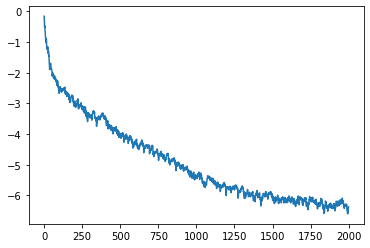

In [3]:
#SGD with mini batch

nbasis = len(basis(0))
theta = np.zeros(nbasis)
alpha = 0.01
nB = 2000
nMB = 5
L0 = []
width = 3
r = np.arange(-width, width, 0.1)

for i in range(nB):
    thetaUpdate = 0
    for j in range(nMB):
        e = np.random.uniform(-width, width)
        actual = f(e)
        b = basis(e)
        fitted = np.dot(b, theta)
        thetaUpdate += alpha * (actual - fitted) * b 
    theta += thetaUpdate
    L0.append(max(abs(f(r) - fittedVal(theta, r))))

plt.plot(np.vectorize(math.log)(L0))

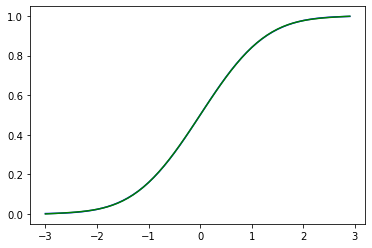

In [4]:
plt.plot(r, f(r), 'b', r, fittedVal(theta, r), 'g')

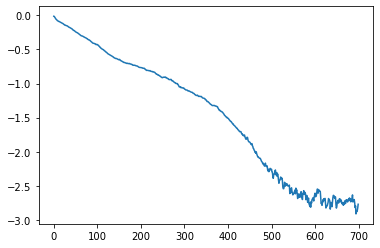

In [128]:
#SGD with mini batch and adagrad

nbasis = len(basis(0))
theta = np.zeros(nbasis)
alpha = 0.001
nB = 700
nMB = 10
L0 = []
l = 0.9
eps = 0.1
width = 5
r = np.arange(-width, width, 0.1)
vecSqrt = np.vectorize(math.sqrt)
g2 = 0
for i in range(nB):
    thetaUpdate = 0
    for j in range(nMB):
        e = np.random.uniform(-width, width)
        actual = fshock(e)
        b = basis(e)
        fitted = np.dot(b, theta)
        thetaUpdate += (actual - fitted) * b 
    grad = thetaUpdate / nB
    g2 = l * g2 + (1 - l) * (thetaUpdate ** 2)
    theta += (alpha / vecSqrt(g2 + eps)) * thetaUpdate
    L0.append(max(abs(f(r) - fittedVal(theta, r))))

plt.plot(np.vectorize(math.log)(L0))

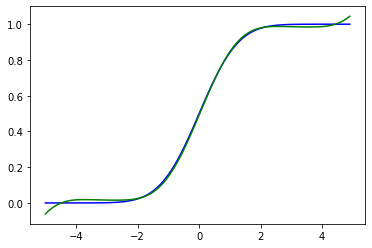

In [127]:
plt.plot(r, f(r), 'b', r, fittedVal(theta, r), 'g')

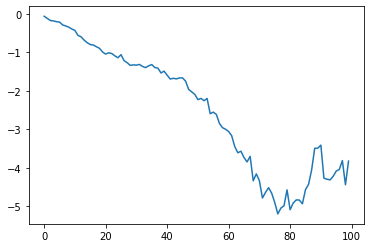

In [130]:
#SGD with mini batch and adagrad

nbasis = len(basis(0))
theta = np.zeros(nbasis)
alpha = 0.01
nB = 100
nMB = 5
L0 = []
l = 0.9
eps = 0.01
width = 4
r = np.arange(-width, width, 0.1)
vecSqrt = np.vectorize(math.sqrt)
g2 = 0
for i in range(nB):
    thetaUpdate = 0
    for j in range(nMB):
        e = np.random.uniform(-width, width)
        actual = f(e)
        b = basis(e)
        fitted = np.dot(b, theta)
        thetaUpdate += (actual - fitted) * b
    grad = thetaUpdate / nB
    g2 = l * g2 + (1 - l) * (thetaUpdate ** 2)
    theta += (alpha / vecSqrt(g2 + eps)) * thetaUpdate
    L0.append(max(abs(f(r) - fittedVal(theta, r))))

plt.plot(np.vectorize(math.log)(L0))

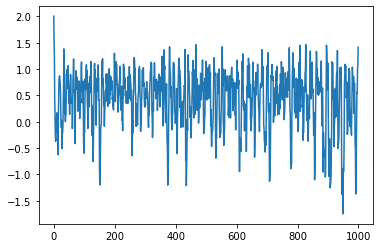

In [131]:
#SGD with mini batch and adagrad and rbf

nbasis = 100
theta = np.zeros(nbasis + 3)
alpha = 0.05
nB = 1000
nMB = 10
L0 = []
l = 0.9
eps = 0.01
epsRbf = 0.1
width = 5
r = np.arange(-width, width, 0.01)
vecSqrt = np.vectorize(math.sqrt)
g2 = 0

pts = np.arange(-width, width, 2 * width / nbasis)

for i in range(nB):
    thetaUpdate = 0
    e = np.random.uniform(-width, width, nMB)
    actual = fshock(e)
    b = rbfbasis(e, pts, 1.0)
    fitted = theta.dot(np.array(rbfbasis(e, pts, epsRbf)))
    thetaUpdate += (actual - fitted) * b 
    thetaSumUpdate = np.array(thetaUpdate).sum(axis=1)
    grad = thetaSumUpdate / nB
    g2 = l * g2 + (1 - l) * (thetaSumUpdate ** 2)
    theta += (alpha / vecSqrt(g2 + eps)) * thetaSumUpdate
    L0.append(max(abs(f(r) - theta.dot(rbfbasis(r, pts, epsRbf)))))

plt.plot(np.vectorize(math.log)(L0))